In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.utils import shuffle
import sys

In [2]:

def load_and_preprocess_images(dataset_folder, image_size=(128, 128)):
    image_data = []
    labels = []

    for data_type in ["train", "test"]:
        data_folder = os.path.join(dataset_folder, data_type)

        for label_idx, label_name in enumerate(os.listdir(data_folder)):
            label_folder = os.path.join(data_folder, label_name)

            for image_filename in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                
                # Check if the image was loaded successfully
                if image is None:
                    print(f"Failed to load image: {image_path}")
                    continue
                
                # Resize the image to the desired size (128x128 pixels)
                image = cv2.resize(image, image_size)
                image = image.flatten()  # Flatten the image
                image_data.append(image)
                labels.append(label_name)

    return np.array(image_data), np.array(labels)

In [3]:
dataset_folder = "Dataset"

# Load and preprocess images
X, y = load_and_preprocess_images(dataset_folder)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)

# Create a DataFrame for the pixel values and labels
data = pd.DataFrame(X)
data.insert(0, "label", y) 

# Save the DataFrame to a CSV file
csv_filename = "dataset.csv"
data.to_csv(csv_filename, index=False)

print(f"Dataset saved to {csv_filename}.")







Dataset saved to dataset.csv.


In [2]:
data = pd.read_csv("dataset.csv")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Columns: 16385 entries, label to 16383
dtypes: int64(16385)
memory usage: 732.0 MB


In [4]:
# Extract features (pixel values) and labels
X = data.iloc[:, 1:].values  # Features (pixel values)
y = data.iloc[:, 0].values   # Labels
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize the pixel values (scaling to the range [0, 1])
X_train = X_train / 255.0
X_test = X_test / 255.0


In [5]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = len(np.unique(y_train))

In [6]:
# Initialize weights and biases
def init_params():
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    b2 = np.zeros((output_size, 1))
    return W1, b1, W2, b2

In [7]:
# Define the ReLU activation function
def relu(Z):
    return np.maximum(0, Z)

# Define the softmax activation function
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z))  # Subtracting max(Z) for numerical stability
    return exp_Z / exp_Z.sum(axis=0, keepdims=True)

In [8]:
# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Compute the cross-entropy loss
def compute_loss(A2, y):
    m = y.shape[0]
    logprobs = -np.log(A2[y, range(m)])
    loss = np.sum(logprobs) / m
    return loss

In [9]:
# Backpropagation
def backward_propagation(X, y, Z1, A1, Z2, A2, W1, W2, b1, b2):
    m = X.shape[1]
    one_hot_Y = np.zeros((output_size, m))
    one_hot_Y[y, range(m)] = 1
    
    dZ2 = A2 - one_hot_Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    return dW1, db1, dW2, db2

In [10]:
# Update parameters using gradient descent
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2


In [11]:
# Training the neural network
def train_neural_network(X_train, y_train, hidden_size, output_size, learning_rate, num_epochs):
    W1, b1, W2, b2 = init_params()
    costs = []
    
    for epoch in range(num_epochs):
        # Forward propagation
        Z1, A1, Z2, A2 = forward_propagation(X_train, W1, b1, W2, b2)
        
        # Compute cost
        cost = compute_loss(A2, y_train)
        
        # Backpropagation
        dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, Z1, A1, Z2, A2, W1, W2, b1, b2)
        
        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        # Print cost for every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Cost = {cost:.4f}")
        
        costs.append(cost)
    
    # Plot the cost curve
    plt.plot(costs)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.title("Cost Curve")
    plt.show()
    
    return W1, b1, W2, b2


Epoch 0: Cost = 0.6805
Epoch 10: Cost = 0.5798
Epoch 20: Cost = 0.5703
Epoch 30: Cost = 0.5588
Epoch 40: Cost = 0.5443
Epoch 50: Cost = 0.5259
Epoch 60: Cost = 0.5027
Epoch 70: Cost = 0.4748
Epoch 80: Cost = 0.4433
Epoch 90: Cost = 0.4106
Epoch 100: Cost = 0.3794
Epoch 110: Cost = 0.3514
Epoch 120: Cost = 0.3277
Epoch 130: Cost = 0.4474
Epoch 140: Cost = 0.3956
Epoch 150: Cost = 0.3647
Epoch 160: Cost = 0.3524
Epoch 170: Cost = 0.3430
Epoch 180: Cost = 0.3335
Epoch 190: Cost = 0.3248


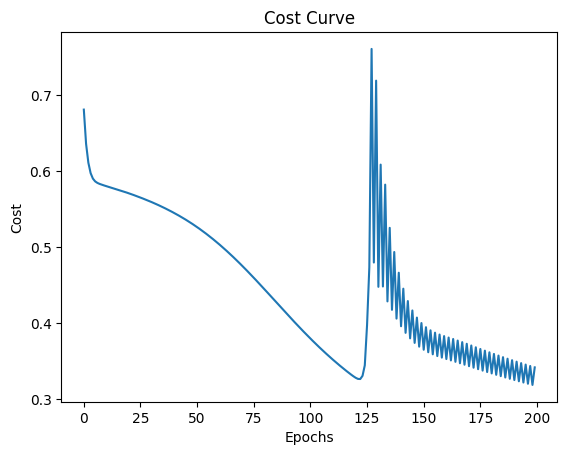

In [12]:
# Train the neural network
trained_W1, trained_b1, trained_W2, trained_b2 = train_neural_network(
    X_train.T, y_train, hidden_size, output_size, learning_rate=0.01, num_epochs=200)

In [15]:
# Evaluate the neural network on the test set
def evaluate_neural_network(X_test, y_test, W1, b1, W2, b2):
    Z1, A1, Z2, A2 = forward_propagation(X_test, W1, b1, W2, b2)
    predictions = np.argmax(A2, axis=0)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    clr = classification_report(y_test, predictions)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n",clr)

In [16]:
evaluate_neural_network(X_test.T, y_test, trained_W1, trained_b1, trained_W2, trained_b2)

Accuracy: 0.8660409556313993
F1 Score: 0.9014438166980538
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.90      0.79       330
           1       0.96      0.85      0.90       842

    accuracy                           0.87      1172
   macro avg       0.83      0.88      0.85      1172
weighted avg       0.89      0.87      0.87      1172

